# LAB – Clasificación de default con SVC 

Este cuaderno implementa **todos los pasos requeridos en `homework.py`** con explicaciones breves por celda.
El flujo es:

1) **Limpieza de datos**  
2) **División en X/y (train/test)**  
3) **Pipeline**: One‑Hot Encoding → PCA (todas las componentes) → Estandarización → SelectKBest → SVC  
4) **Optimización con validación cruzada (10 folds)** usando *balanced accuracy*  
5) **Guardado del modelo** (`files/models/model.pkl.gz`)  
6) **Cálculo de métricas** (train y test) y guardado en `files/output/metrics.json`  
7) **Matriz de confusión (train y test)** → se guarda en `metrics.json` **y se grafica la del conjunto de prueba**

## Paso 1 — Limpieza de los datasets
- Renombro la columna objetivo a `default`.
- Remuevo `ID`.
- Elimino registros con información no disponible (NA).
- Para `EDUCATION`, agrupo valores > 4 en la categoría `others` (valor 4).

In [8]:
# === Carga robusta: busca 'files/input' hacia arriba si hace falta ===
from pathlib import Path
import pandas as pd
import numpy as np

def find_base_with(*folders, max_up=4):
    here = Path.cwd()
    for up in range(max_up+1):
        cand = here
        for _ in range(up):
            cand = cand.parent
        if all((cand / f).exists() for f in folders):
            return cand
    return Path.cwd()  # fallback

BASE = find_base_with("files", "files/input")

TRAIN = BASE / "files" / "input" / "train_data.csv.zip"
TEST  = BASE / "files" / "input" / "test_data.csv.zip"

print(f"Usando archivos:\n  TRAIN: {TRAIN}\n  TEST : {TEST}")

df_train = pd.read_csv(TRAIN, compression="zip")
df_test  = pd.read_csv(TEST, compression="zip")

# Renombrar la variable objetivo y eliminar ID
df_train = df_train.rename(columns={"default payment next month": "default"})
df_test  = df_test.rename(columns={"default payment next month": "default"})

if "ID" in df_train.columns:
    df_train = df_train.drop(columns=["ID"])
if "ID" in df_test.columns:
    df_test = df_test.drop(columns=["ID"])

# EDUCATION > 4 => 4 (others)
if "EDUCATION" in df_train.columns:
    df_train["EDUCATION"] = df_train["EDUCATION"].where(df_train["EDUCATION"] <= 4, 4)
if "EDUCATION" in df_test.columns:
    df_test["EDUCATION"] = df_test["EDUCATION"].where(df_test["EDUCATION"] <= 4, 4)

# Eliminar filas con NA
df_train = df_train.dropna().reset_index(drop=True)
df_test  = df_test.dropna().reset_index(drop=True)

df_train.shape, df_test.shape

Usando archivos:
  TRAIN: c:\Users\fabi2\OneDrive\Escritorio\2025-2S\AP\LAB-03-prediccion-del-default-usando-svc-fhurtadoa\files\input\train_data.csv.zip
  TEST : c:\Users\fabi2\OneDrive\Escritorio\2025-2S\AP\LAB-03-prediccion-del-default-usando-svc-fhurtadoa\files\input\test_data.csv.zip


((21000, 24), (9000, 24))

## Paso 2 — División en X/y (train/test)
Separamos `X_train`, `y_train`, `X_test`, `y_test`.

In [9]:
target_col = "default"
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col].astype(int)

X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col].astype(int)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21000, 23), (9000, 23), (21000,), (9000,))

## Paso 3 — Pipeline
El pipeline solicitado incluye, en orden:
1. **One‑Hot Encoding** para las categóricas.
2. **PCA** con *todas* las componentes.
3. **Estandarización** con `StandardScaler`.
4. **Selección de K mejores** con `SelectKBest`.
5. **Clasificador SVC**.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.feature_selection import f_classif,SelectKBest
from sklearn.svm import SVC


categorical_features=["SEX","EDUCATION","MARRIAGE"]
numerical_features=num_columns = [col for col in X_train.columns if col not in categorical_features]


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('scaler',StandardScaler(with_mean=True, with_std=True),numerical_features),
    ],
)


pipeline=Pipeline(
    [
        ("preprocessor",preprocessor),
        ('pca',PCA()),
        ('feature_selection',SelectKBest(score_func=f_classif)),
        ('classifier', SVC(kernel="rbf",random_state=12345,max_iter=-1))
    ]
)


## Paso 4 — Optimización (10 folds, *balanced accuracy*)
Se ajusta una búsqueda en rejilla sobre `kbest__k`, `clf__kernel`, `clf__C` y `clf__gamma`.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score


param_grid = {
    'pca__n_components':[20,X_train.shape[1]-2],
    'feature_selection__k':[12],
    'classifier__kernel': ['rbf'],
    'classifier__gamma': [0.1],
}

model=GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring="balanced_accuracy",
    n_jobs=-1,
    refit=True
    )

model.fit(X_train, y_train)

,estimator,Pipeline(step...tate=12345))])
,param_grid,"{'classifier__gamma': [0.1], 'classifier__kernel': ['rbf'], 'feature_selection__k': [12], 'pca__n_components': [20, 21]}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('scaler', ...)]"


## Paso 5 — Guardado del modelo
Se guarda comprimido en `files/models/model.pkl.gz` usando `gzip`.

In [12]:
import pickle
import os
import gzip

models_dir = '../files/models'
os.makedirs(models_dir, exist_ok=True)

compressed_model_path = "../files/models/model.pkl.gz"

with gzip.open(compressed_model_path, "wb") as file:
    pickle.dump(model, file)


## Paso 6 — Métricas (train y test)
Se calculan `precision`, `balanced_accuracy`, `recall` y `f1_score` en entrenamiento y prueba, y se guardan en `files/output/metrics.json` (formato **JSON Lines**: una fila por diccionario).

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
from pathlib import Path
import json

best = model.best_estimator_

yhat_train = best.predict(X_train)
yhat_test  = best.predict(X_test)

def metrics_block(y_true, y_pred, dataset):
    return {
        "type": "metrics",
        "dataset": dataset,
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1_score": float(f1_score(y_true, y_pred, zero_division=0)),
    }

m_train = metrics_block(y_train, yhat_train, "train")
m_test  = metrics_block(y_test,  yhat_test,  "test")

OUTPUT_DIR = BASE / "files" / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = OUTPUT_DIR / "metrics.json"

with open(metrics_path, "w", encoding="utf-8") as fh:
    fh.write(json.dumps(m_train) + "\n")
    fh.write(json.dumps(m_test) + "\n")

metrics_path, metrics_path.exists()

(WindowsPath('c:/Users/fabi2/OneDrive/Escritorio/2025-2S/AP/LAB-03-prediccion-del-default-usando-svc-fhurtadoa/files/output/metrics.json'),
 True)

## Paso 7 — Matrices de confusión y gráfico (requerido)
Se calculan las matrices de confusión para train y test, se **guardan** en `metrics.json` (como líneas adicionales) y se **grafica** la del conjunto de **prueba** usando `matplotlib`.

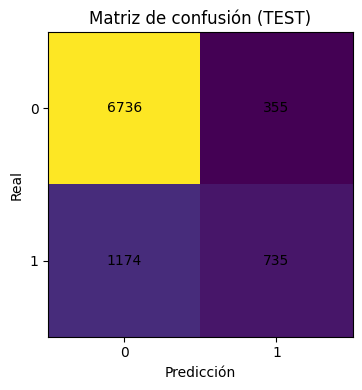

['{"type": "metrics", "dataset": "train", "precision": 0.7013449367088608, "balanced_accuracy": 0.6643417305198113, "recall": 0.3750793314998942, "f1_score": 0.48876636802205375}',
 '{"type": "metrics", "dataset": "test", "precision": 0.6743119266055045, "balanced_accuracy": 0.6674774367407641, "recall": 0.38501833420639076, "f1_score": 0.490163387795932}',
 '{"type": "cm_matrix", "dataset": "train", "true_0": {"predicted_0": 15518, "predicted_1": 755}, "true_1": {"predicted_0": 2954, "predicted_1": 1773}}',
 '{"type": "cm_matrix", "dataset": "test", "true_0": {"predicted_0": 6736, "predicted_1": 355}, "true_1": {"predicted_0": 1174, "predicted_1": 735}}']

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def cm_block(y_true, y_pred, dataset):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return {
        "type": "cm_matrix",
        "dataset": dataset,
        "true_0": {"predicted_0": int(cm[0,0]), "predicted_1": int(cm[0,1])},
        "true_1": {"predicted_0": int(cm[1,0]), "predicted_1": int(cm[1,1])},
    }

cm_train = cm_block(y_train, yhat_train, "train")
cm_test  = cm_block(y_test,  yhat_test,  "test")

# Append de matrices al mismo metrics.json
with open(metrics_path, "a", encoding="utf-8") as fh:
    fh.write(json.dumps(cm_train) + "\n")
    fh.write(json.dumps(cm_test) + "\n")

# --- Gráfico de la matriz de confusión del conjunto de prueba ---
cm = confusion_matrix(y_test, yhat_test, labels=[0, 1])

fig = plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Matriz de confusión (TEST)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks([0,1], ["0","1"])
plt.yticks([0,1], ["0","1"])

# Anotar valores
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

metrics_path.read_text().splitlines()[-4:]  # mostramos últimas líneas escritas